# Movie Data Analysis

The purpose of this project is to analyze data from a variety of sources to create a slate of content produced by a new company entering the video streaming marketplace. For the sake of this project, I am assuming I am pitching this project to Microsoft Studios, a fictional film studio.

### The Data
The data used for the project was pulled from these various sources:
- IMDB - The International Movie Database
- TMDB - The Movie Database
- Movie Production Budget and Box Office Gross Data

This project is unconcerned with critical failures, but rather what makes a recipe for success? Therefore, I will only focus on data from films with the highest audience vote counts on both IMDB and TMDB, to avoid massive outliers.

## What Makes a Streaming Company Succesful?
This is the major question at the heart of this project. Any new streaming service will need a mixture of both original and licensed content covering a multitude of genres and styles. Because of this, unless the company is targeting a niche market, all original content should try to reach as broad an audience as possible. Therefore this project will ask the following questions:

- Does Production Budget affect Popularity?
- What Genres of film are most popular? Are the best financial investment? Have the highest quality?
- What actors, producers, directors and writers should you hire to create this content?

This project will answer all of the above with recommendations for a new streaming service. Below you will find the initial packages installed to help with this analysis as well as the import of data from the file 'zippedData' in the GitHub Repository.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import all data files.
professional_names_df = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
title_key_df = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
imdb_genres_df = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
crew_df = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
imdb_ratings_df = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
tmdb_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
budget_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

## Functions

### Data Cleaning 
The following functions are used to clean the initial dataframes imported from the data files. The most important function is clean_title that acts as the primary key to join movies. Movie titles can take many different forms so, in order to join dataframes using the name as the key we need to reduce the title to its simplest parts (i.e. removing punction or extraneous dates) and then we need to add the year because movies of the same title do exist, but tend to not get released in the same annual period.

In [3]:
def clean_title(title):
    
    '''
    Takes a string and normalizes it by removing excess symbols that could be ambiguous
    Also removes any dates attached to titles. These will be added back in during data cleaning.
    '''
    
    c_title = ''
    l_title = title.lower()
    
    word_list = l_title.split()
    
    for word in word_list:
        if word[0] == '(':
            break
        else:
            word = word.replace('?','')
            word = word.replace('/','')
            word = word.replace('!','')
            word = word.replace('–','')
            word = word.replace('-','')
            word = word.replace('&','and')
            word = word.replace('ep.','episode')
            word = word.replace(':','')
            word = word.replace(',','')
            word = word.replace('.','')
            word = word.replace("'","")
            word = word.replace("`",'')
        
            c_title += word.title()
    
    return c_title

In [4]:
def separate_values(string):
    '''
    Splits any string by a comma and then returns a list of values
    '''
    if type(string) == str:
        value_list = string.split(',')
    else:
        return string
    
    return value_list

In [5]:
def clean_money(string):
    '''
    Takes money objects and turns it into a float
    '''
    if type(string) == str:
        answer = string.replace('$','')
        answer = answer.replace(',','')
        answer = float(answer)
    else:
        return string
    return answer

### Visualization Functions
These are used to aggregate and demonstrate data trends in the final dataframes of the project. Each one is designed to call multiple dataframes as well as a single column in question (each of which is an important metric from the following list: Return on Investment in Dollars, Return on Investment in percentage of production budget, TMDB popularity and TMDB Quality. 

In [6]:
def genre_counts(dataframe,column):
    '''
    Takes in a dataframe and a column. Orders the DF by the values in the column in question, cuts in down
    to the top 100 entries. Counts how many of the movies have each genre and then plots a horizontal
    bar graph to show top genres by the column metric. 
    '''
    df = dataframe.sort_values(by=[column],ascending=False)
    df = df.iloc[:100]
    df = pd.DataFrame(df[list(genre_set)].sum())
    df.columns = ['count']
    df.sort_values(by='count',ascending=False,inplace=True)
    plt.figure(figsize=(7,7))
    x_values = list(df['count'])
    y_values = list(df.index)
    plt.title(f'Genres ordered by {column}')
    plt.xlabel('Number of Movies')
    plt.ylabel('Genres')
    return sns.barplot(y=y_values,x=x_values, data=df, orient='h');

In [7]:
def top_crew(dataframe,column):
    '''
    Takes a crew dataframe dictionary and finds the mean of the column metric in question and then plots a bar graph
    of the top fifty entries
    '''
    name = dataframe['name']
    df = dataframe['df'].groupby(by=dataframe['df']['primary_name']).mean().sort_values(by=f'{column}',ascending=False)
    df = df.iloc[:20]
    plt.figure(figsize=(5,10))
    x_values = list(df[f'{column}'])
    y_values = list(df.index)
    plt.title(f'{name} by {column}')
    return sns.barplot(x = x_values, y = y_values, data = df)

### Functions for Data Export
This final function produces a list of the top thirty actors, directors, producers and screenwriters based on a desired metric. The output is a simple table that can be easily exported into excel.

In [8]:
def create_top_df(list_of_dfs,column_name):
    
    '''
    Takes in a list of dataframe dictionaries of the format {'df':dataframe,'name':'name of dataframe'} as well as
    a column in question. It will produce a dataframe of the top thirty Actors, Directors, Producers and Writers of
    that particular metric.
    '''
    
    final_list = []
    
    for dataframe in list_of_dfs:
        name = dataframe['name']
        df = dataframe['df'].groupby(by=dataframe['df']['primary_name']).mean().sort_values(by=f'{column_name}',ascending=False)
        df = df.iloc[:30]
        df.reset_index(inplace=True)
        df = df.loc[:, ['primary_name']]
        df.rename(columns={'primary_name':f'{name}'},inplace=True)
        final_list.append(df)
    
    final_df = final_list[0].join(final_list[1:])
    final_df.rename_axis(f"By {column_name.title()}",inplace = True)
    return final_df

## Data Cleaning

The following cells are the code that joins all requisite data into a single dataframe called 'super_vote_df'. This dataframe includes data covering genre, popularity, production budget, return on investment, and critical quality. It also adds columns to indicate which genres the film belongs to. 

In [9]:
# Creates the IMDB table to add to other tables. Includes title_id for merging as well as genres
imdb_genres_df.rename(columns={'tconst':'title_id'},inplace=True)
imdb_df = title_key_df.merge(imdb_genres_df,how='left',on='title_id')
imdb_df = imdb_df.loc[:,['title_id','title','primary_title','start_year','runtime_minutes','genres']]
imdb_df['clean_title'] = imdb_df.title.map(lambda x: clean_title(x))

#Renames columns to clean. Splits genres into a list that can be parsed later.
imdb_df.rename(columns={'start_year':'year','runtime_minutes':'runtime'},inplace=True) #Change year into string?
imdb_df['clean_title'] = imdb_df['clean_title'] + " " + imdb_df['year'].astype(str)


In [10]:
#Joins budget table with IMDB t-const - Goes from 5782 records to 4069
budget_df.rename(columns={'movie':'title'},inplace=True)
budget_df['year'] = budget_df.release_date.map(lambda x: x.split()[-1])
budget_df['clean_title'] = budget_df.title.map(lambda x: clean_title(x))
budget_df['clean_title'] = budget_df['clean_title'] + ' ' + budget_df['year'].astype(str)

budget_tconst_df = budget_df.merge(imdb_df, how='left',on='clean_title')
budget_tconst_df.drop_duplicates(inplace=True)
budget_tconst_df.drop(columns=['title_y','year_y'],inplace = True)
budget_tconst_df.rename(columns={'title_x':'title','year_x':'year'},inplace=True)
# budget_tconst_df.drop_duplicates(subset='title_id',inplace = True)

#Turns money columns into floats from objects
budget_tconst_df['production_budget'] = budget_tconst_df.production_budget.map(lambda x: clean_money(x)) 
budget_tconst_df['domestic_gross'] = budget_tconst_df.domestic_gross.map(lambda x: clean_money(x))
budget_tconst_df['worldwide_gross'] = budget_tconst_df.worldwide_gross.map(lambda x: clean_money(x))
final_budget_df = budget_tconst_df

### Return on Investment

I chose Return on Investment as one of the major metrics for a few reasons. For a film to gain the most possible profit it would require the necessary intersection of quality filmmaking as well as general popularity. Looking only at box office gross could be deeply misguided as the film 'Dark Phoenix' outperformed the film 'The Blair Witch Project' by a few million, but because 'Dark Phoenix cost over 200 million dollars to make, it lost a substantial amount of money while, as you will see, The Blair Witch Project is the second most successful film of all time when considering Return on Investment as a percentage of the original budget.

### Why?
For streaming movies, it is difficult to measure the value a single film brings to a streaming service's portfolio because no streaming company publishes their viewing data. However, general popularity of a film is a good indicator of an audience's interest in paying more money for another streaming service. ROI is the best monetary indicator of popularity.

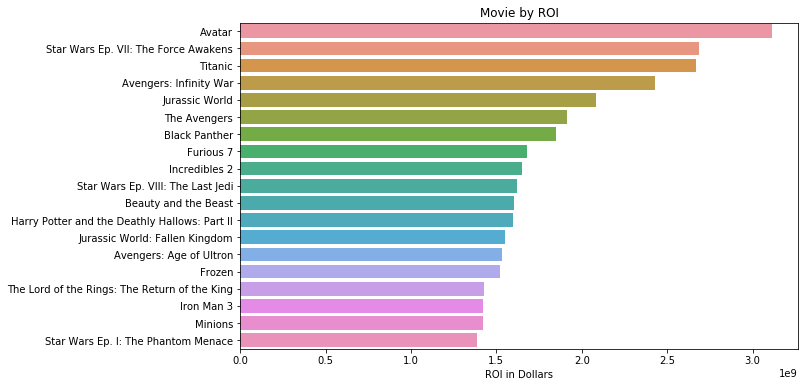

In [46]:
#Creates an ROI column for films and creates a column with a boolean value based on whether or not it's profitable
final_budget_df['ROI'] = final_budget_df['worldwide_gross'] + final_budget_df['domestic_gross'] - final_budget_df['production_budget']
final_budget_df['ROI%'] = final_budget_df['ROI']/final_budget_df['production_budget']
budget_ROI_df = final_budget_df.sort_values(by='ROI',ascending=False)
budget_ROI_df['Profitable'] = budget_ROI_df.ROI.map(lambda x: x>0)


x_values = list(budget_ROI_df.title[:20])
y_values = list(budget_ROI_df.ROI[:20])

plt.figure(figsize=(10,6))
sns.barplot(y=x_values, x=y_values, data = final_budget_df, orient='h')
plt.xlabel('ROI in Dollars')
plt.title('Movie by ROI');
plt.xticks
plt.savefig('movie_roi.png')

Already we can see that the movies that create the most profit tend to be big budget action adventure movies. Avatar, famously the most expensive movie of all time, is also the most profitable (a bold bet). However, we can see some interesting patterns that emerge when we consider other metrics.

## Return on Investment as a Percentage

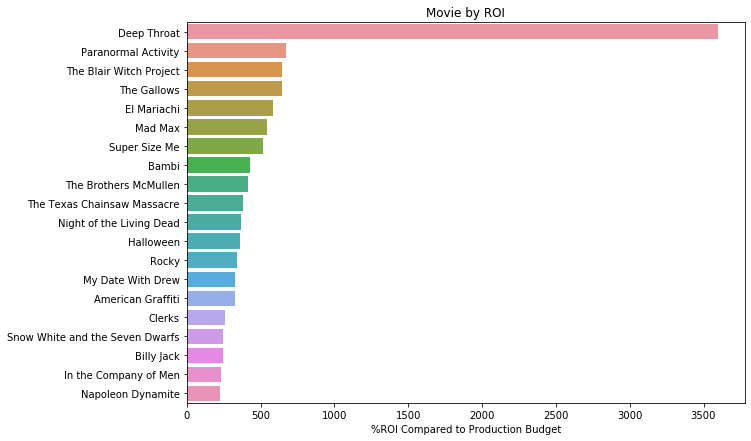

In [12]:
final_budget_df['ROI%'] = final_budget_df['ROI']/final_budget_df['production_budget']
budget_ROI_df = budget_ROI_df.sort_values(by='ROI%',ascending=False)

x_values = list(budget_ROI_df.title[:20])
y_values = list(budget_ROI_df['ROI%'][:20])

plt.figure(figsize=(10,7))
sns.barplot(y=x_values, x=y_values, data = final_budget_df, orient='h')
plt.xlabel('%ROI Compared to Production Budget')
plt.title('Movie by ROI');

When we divide the ROI of a movie by its original budget, we find a completely different and fascinating list of films. Instead of being large budget action films, they are cheaper, smaller horror movies (if we ignore the obvious outlier of 'Deep Throat'). Avatar, while record breakingly successful, made back 100% of its budget in profits. Comoparably, Paranormal Activity made over 600% of its budget. 

## Why is this important?

Any streaming service needs a breadth of content. Spending all of your money on a second Avatar would be unwise. Cheaper movies can also be popular, though that is not always the case. Some small budget movies can find massive popularity and essential cult status.

## More Data Cleaning

Below I combine popularity data with financial data to see if audience reactions match the money behind the movie.

In [13]:
#Joins the TMDB table, which includes information regarding popularity by film.
tmdb_df['clean_title'] = tmdb_df.title.map(lambda x: clean_title(x))
tmdb_df['year'] = tmdb_df.release_date.map(lambda x: x.split('-')[0])
tmdb_df['clean_title'] = tmdb_df['clean_title'] + ' ' + tmdb_df['year'].astype(str)

tmdb_tconst_df = tmdb_df.merge(imdb_df,how='inner',on='clean_title')
tmdb_tconst_df.drop_duplicates(subset='title_id',inplace=True)
tmdb_clean_df = tmdb_tconst_df.loc[:, ['popularity','vote_average','vote_count','clean_title','title_id']]

In [14]:
#Creates Super_df that contains ROI, popularity, IMDB rating and vote counts.
imdb_ratings_df.rename(columns={'tconst':'title_id'},inplace=True)
super_df = budget_ROI_df.merge(tmdb_clean_df,how='left',on='title_id')
super_df = super_df.merge(imdb_ratings_df,how='left',on='title_id')
super_df.drop(columns=['clean_title_y'],inplace=True)

## Question 1 - What is the Relationship between Budget and Popularity?


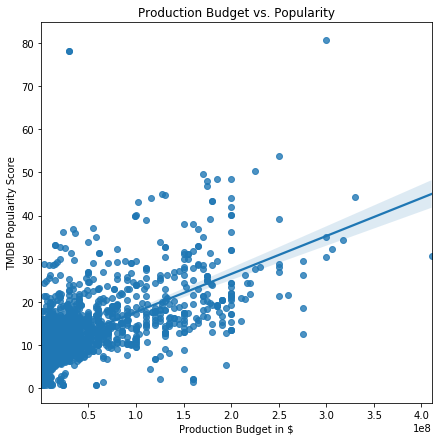

In [15]:
#Creates Linear Regression showing relationship between production budget and popularity
plt.figure(figsize=(7,7))

sns.regplot(x=super_df.production_budget, y=super_df.popularity, data=super_df)
plt.title('Production Budget vs. Popularity');
plt.xlabel('Production Budget in $')
plt.ylabel('TMDB Popularity Score');

This is a linear regression charting the relationship between production budget (in dollars) and TMDB popularity score. As you can see there is a positive, linear relationship between the two metrics. This makes sense, as marketing is a large part of the Production Budget. Also, popular actors tend to require more money and, for many years, most films are sold on the talent on screen, hence the higher cost.

Interestingly, there is a vertical cluster at the 200 Million Dollar range. 200M has become the standard budget for a summer blockbuster movie, so you can see the popularity of those films varies wildly.

## Question 2 - What Genres Should We Focus On?

The easiest way to identify most movies is by their genre. Genres are both an artistic style as well as a marketing tool. Of the films analyzed, the genres were assigned by IMDB, and most films have multiple genres. This section seeks to ask the following questions:

1. What genre(s) produce the greatest ROI?
2. What genre(s) produce the greatest ROI%?
3. What genre(s) have the highest critical praise?
4. What genre(s) are the most popular?

While similar, all three questions encourage a very different style of content that could increase the success of a new streaming company. But first, more data cleaning

In [16]:
#Creates list of genres from the IMDB dataframes
genre_list = list(super_df.genres)
genre_list2 = []

#iterates through the list and adds the genres to a set to get a set of unique values
for item in genre_list:
    if type(item) == str:
        new_list = item.split(',')
        for genre in new_list:
            genre_list2.append(genre)

genre_set = set(genre_list2)

In [17]:
# drops 36 films that do not have genres
super_df.dropna(subset=['genres'],inplace=True)

In [18]:
# creates a column for each genre populated with a boolean value if it is in the genre list for that movie.
for genre in list(genre_set):
    super_df[f'{genre}'] = super_df.genres.map(lambda x: genre in x)

In [19]:
# Used this to figure out 25% quartile
super_df.vote_count.describe()

count     1682.000000
mean      2175.905470
std       2894.528106
min          1.000000
25%        307.750000
50%       1078.000000
75%       2813.250000
max      22186.000000
Name: vote_count, dtype: float64

In [20]:
# Creates a version of the super_df but with only movies having both more than 500 IMDB votes and 20000 TMDB votes
super_df.rename(columns={'vote_average':'IMDB Quality','averagerating':'TMDB Quality','clean_title_x':'clean_title'},inplace=True)
super_vote_df = super_df.loc[(super_df.vote_count > 500) & (super_df.numvotes > 20000)]

### Genre by Return on Investment
As you can see, Action/Adventure movies tend to return the highest profits. These are going to be the blockbuster films of the streaming service. An action/adventure science fiction film, like any of the Marvel movies, or The Matrix, have proven to be massively popular with audiences, hence their profitable nature

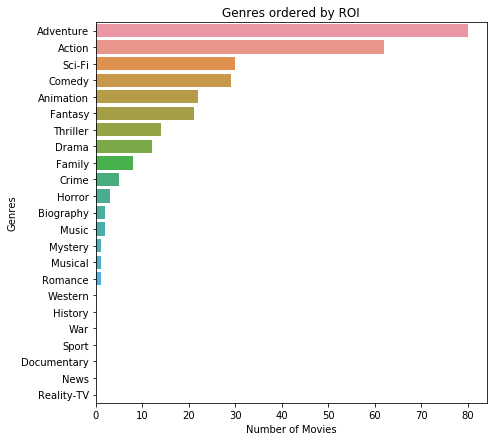

In [21]:
genre_counts(super_vote_df,'ROI');

### Genre by Popularity
Using the TMDB popularity score, we can see that the most popular genres are also the most profitable. Comedies tend to not be as popular as, say, dramas in this category, but Science Fiction Action/Adventure is still the genre combination that will draw the greatest audience.

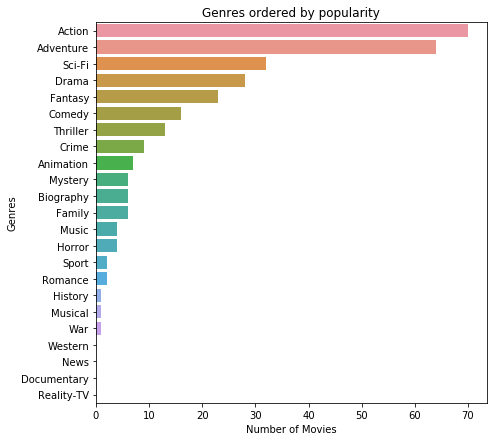

In [22]:
genre_counts(super_vote_df,'popularity');

### Genre by Quality
Movies are sometimes described a 'prestige' meaning that, while they might not sell the most tickets at the movieplex, they stand in good ground with critics. A streaming service should have a fair share of blockbuster popular titles, but it should also have so genuine quality work as well. While Action/Adventures still rank high on this metric, Drama is the most important genre to woo critics.

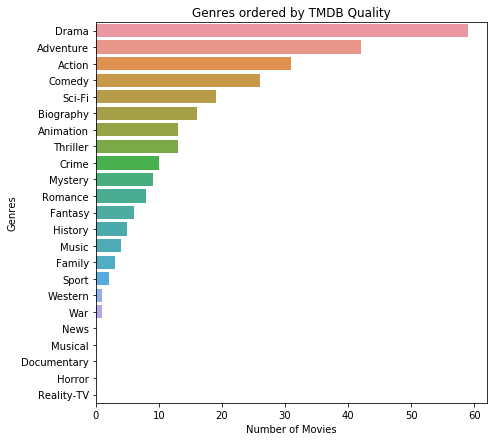

In [23]:
genre_counts(super_vote_df,'TMDB Quality');

### Genre by ROI%
Below you see genres ordered by how successful a movie was against its original budget. These films have the greatest difference between their production budget and their popularity. Films like these should require very little money, comparatively, but could draw large audiences. Similar to 'Quality', Dramas are the highest rated here. This makes sense because most 'Oscar' films tend to have low budgets (compared to, say, the Fast and the Furious films) and high cultural value because they have been nominated for awards. 

We can also see that Horror and Thriller are the next two genres. These films tend to be audience pleasers and can be made extremely cheaply. The Blair Witch Project was the 2nd most successful film of all time until Paranormal Activity, a similarly cheap and effective horror film, took its place.

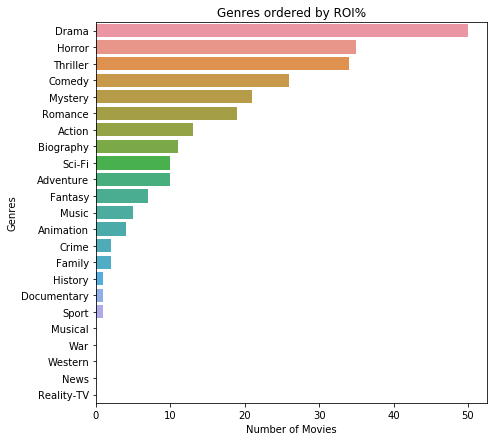

In [24]:
genre_counts(super_vote_df,'ROI%');

## Question 3 - Who should we hire?

The success of any movie is determined by the creative team behind it. In general, the most marketable people working on a film are the following:

1. Actors
2. Directors
3. Writers
4. Producers

Every one of these roles is essential to the final product. Actors draw crowds and a fanbase. Directors are in charge of the artistic vision of the piece. Writers have to tell a complete and efficient story. And producers have to put it all together in a package that people love. 

Below you will see my data cleaning to join actors, directors, producers and writers onto each movie in the Super_Vote_Df.

In [25]:
# Adds Actors, Directors, Writers and Producers to the super_vote DataFrame
crew_df.rename(columns={'tconst':'title_id'},inplace=True)

crew_df = crew_df.loc[(crew_df.category == 'actor') | (crew_df.category == 'actress') | (crew_df.category == 'producer') | (crew_df.category == 'writer') | (crew_df.category == 'director')]
crew_df = crew_df.merge(professional_names_df, how='left', on='nconst')

crew_df.drop(columns=[
        'characters',
        'job',
        'nconst',
        'ordering',
        'birth_year',
        'death_year',
        'primary_profession',
        'known_for_titles'
    ],inplace=True)

super_crew_df = super_vote_df.merge(crew_df,how='left',on='title_id')

In [26]:
#Creates different dataframes for each of the major crew types for further analysis. Treats actors and actresses equally
actors = super_crew_df.loc[(super_crew_df.category == 'actor') | (super_crew_df.category == 'actress')]
directors = super_crew_df.loc[super_crew_df.category == 'director']
writers = super_crew_df.loc[super_crew_df.category == 'writer']
producers = super_crew_df.loc[super_crew_df.category == 'producer']

In [27]:
# Creates a list of dictionaries used in the create_top_df function.

df_list = [
    {'df':actors,'name':'Actors'}, 
    {'df': directors, 'name': 'Directors'}, 
    {'df': writers,'name':'Writers'}, 
    {'df': producers,'name':'Producers'}
]

## Crew By Popularity

The follow charts are created by taking the mean of each actor's career using the movies in super_vote_df. Some big name actors can be in one or two very popular films, but have some flops too. Below are the actors, directors, writers and producers who have worked on the most popular films during their entire career. 

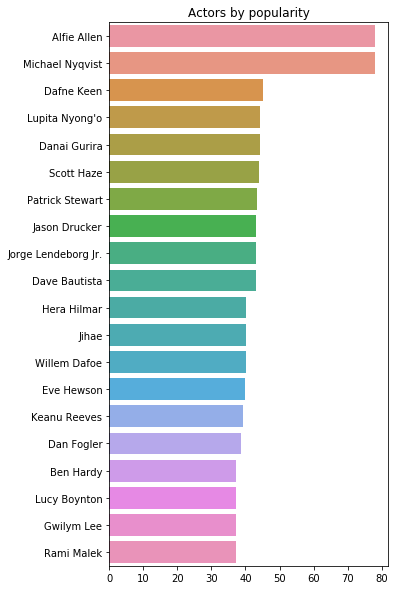

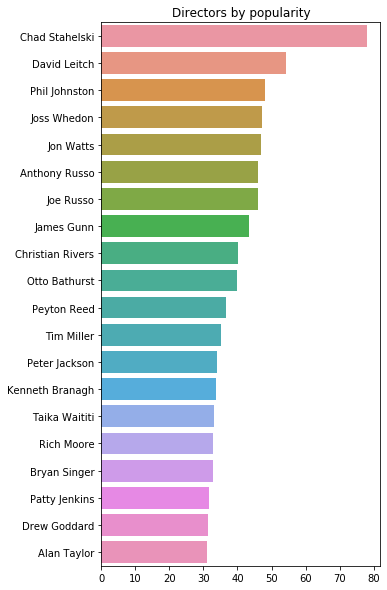

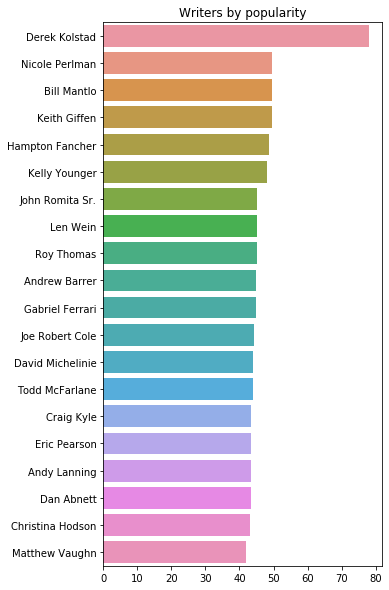

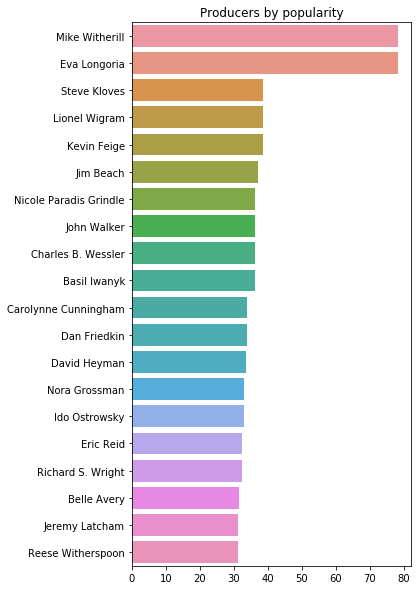

In [28]:
column = 'popularity'

for i in range(len(df_list)):
    top_crew(df_list[i],f'{column}');

## Crew by Return on Investment

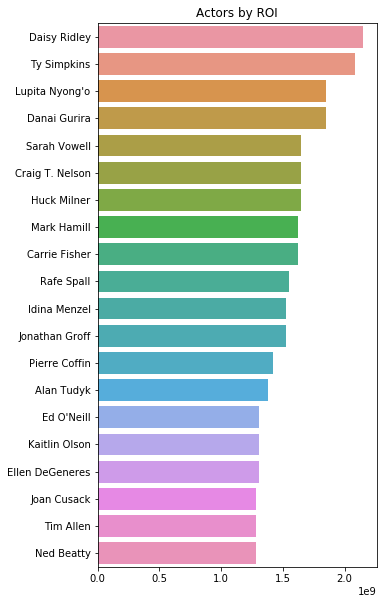

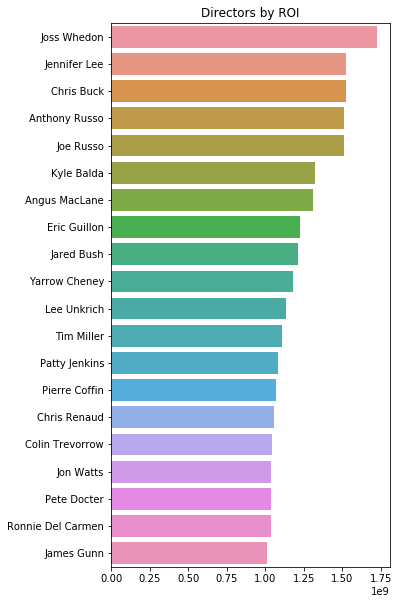

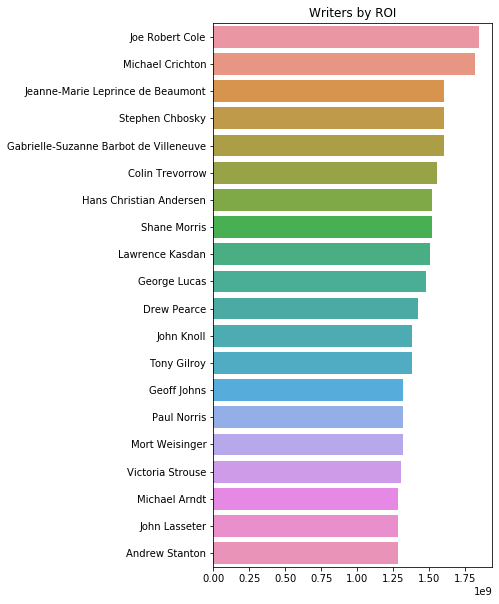

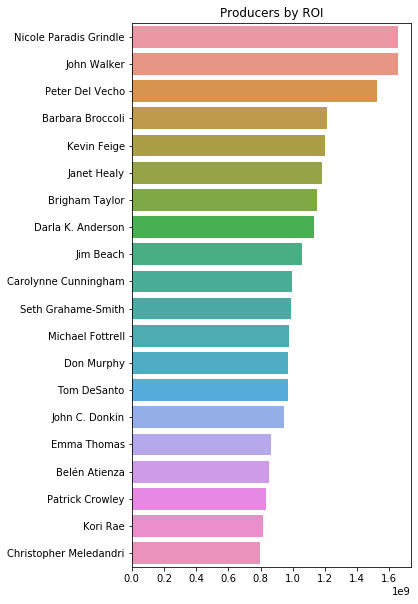

In [29]:
column = 'ROI'

for i in range(len(df_list)):
    top_crew(df_list[i],f'{column}');

## Crew by ROI%

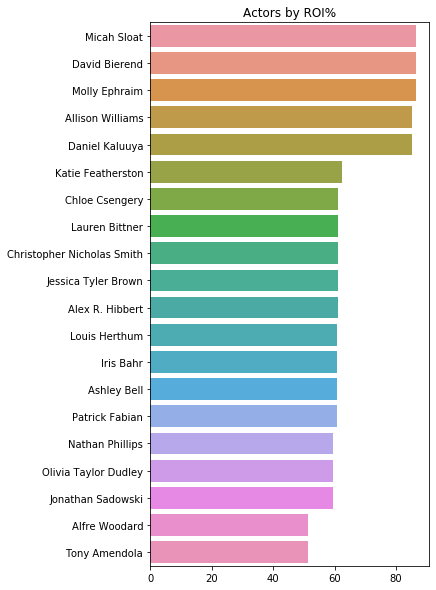

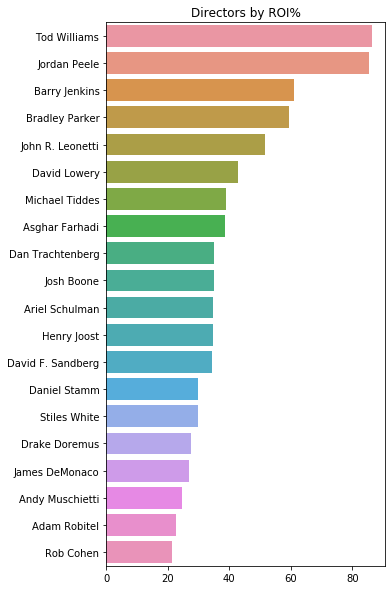

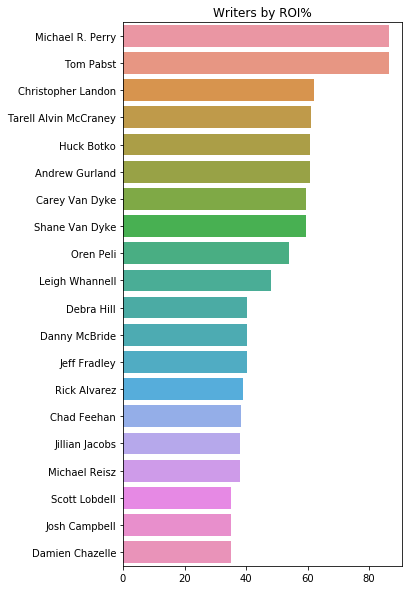

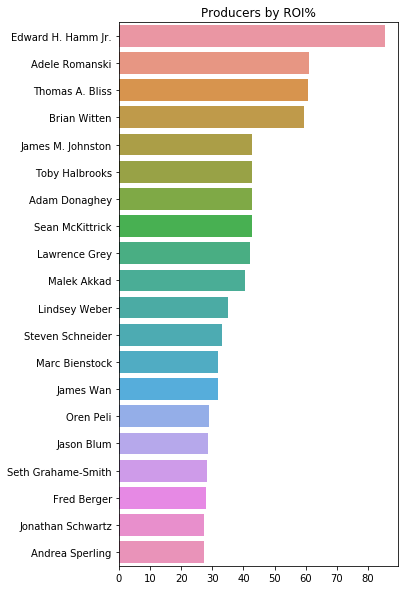

In [30]:
column = 'ROI%'

for i in range(len(df_list)):
    top_crew(df_list[i],f'{column}');

## Crew by TMDB Quality

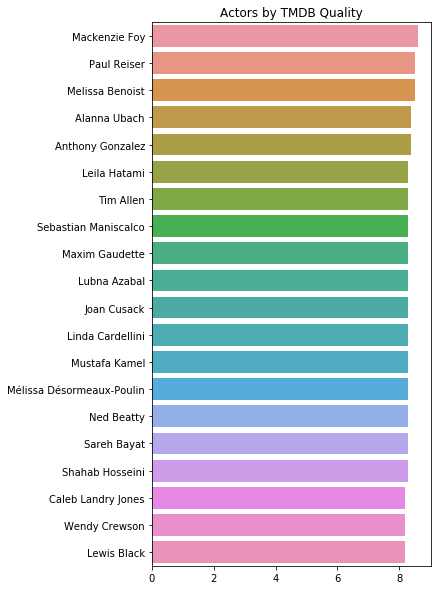

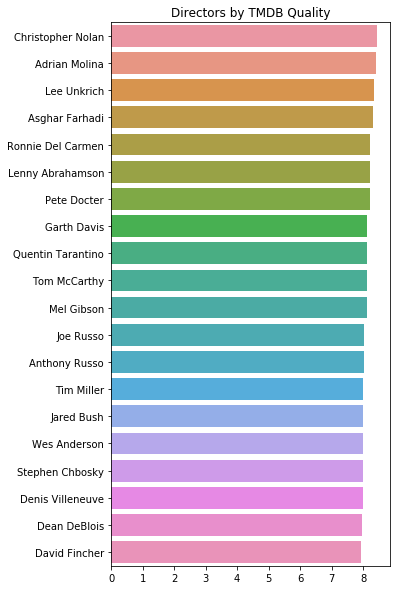

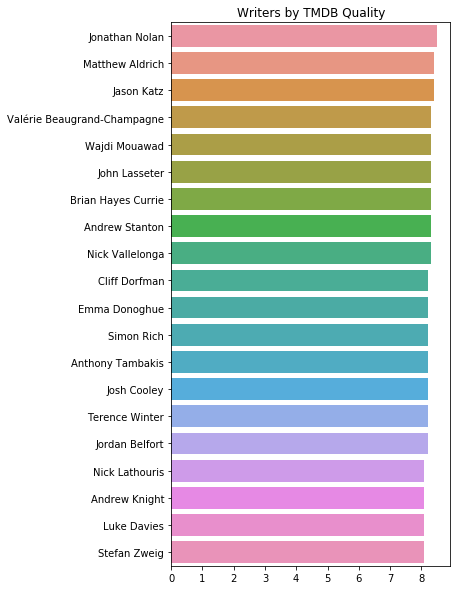

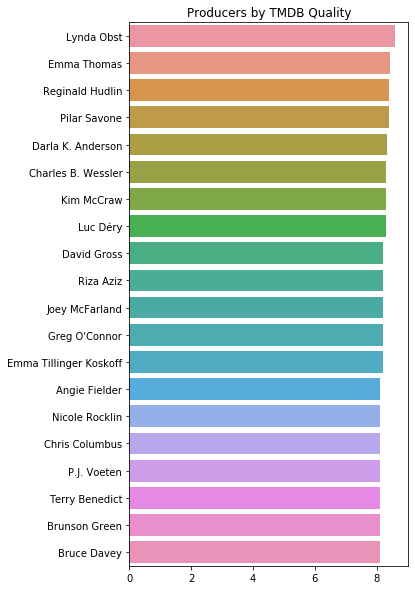

In [31]:
column = 'TMDB Quality'

for i in range(len(df_list)):
    top_crew(df_list[i],f'{column}');

## Conclusions and Exporting the Data

Below you will find the data that was visualization above expanded on and ordered into Dataframes for export into other file formats. For each of the following categories, these are the top 30 artists that you should hire to maximize each metric. While many of the names might seem obscure, these tend to be seasoned veterans in the industry who have worked on some of the most successful films and franchises of all time.

It is clear that any successful streaming service has a wealth of content when it goes live, both original creations and licensed films from other studios. The following conclusions will address each metric we have analyzed and give suggestions for production.

### Conclusion Number 1 - Popularity

First and foremost, movies need to be popular if they expect to make a mark on the streaming market. From the genre analysis, the most popular movies tend to:

- Be Action/Adventure Science Fiction Movies
- Have a high budget (typically greater than 200 million dollars)

Below is a list of directors, actors, producers and writers who have proven to create popular work. Examples of content like this include:

- Stranger Things (Netflix)
- Jack Ryan (Amazon)
- Game of Thrones (HBO)

In [32]:
create_top_df(df_list,'popularity')

,Actors,Directors,Writers,Producers
By Popularity,,,,
0,Alfie Allen,Chad Stahelski,Derek Kolstad,Mike Witherill
1,Michael Nyqvist,David Leitch,Nicole Perlman,Eva Longoria
2,Dafne Keen,Phil Johnston,Bill Mantlo,Steve Kloves
3,Lupita Nyong'o,Joss Whedon,Keith Giffen,Lionel Wigram
4,Danai Gurira,Jon Watts,Hampton Fancher,Kevin Feige
5,Scott Haze,Anthony Russo,Kelly Younger,Jim Beach
6,Patrick Stewart,Joe Russo,John Romita Sr.,Nicole Paradis Grindle
7,Jason Drucker,James Gunn,Len Wein,John Walker
8,Jorge Lendeborg Jr.,Christian Rivers,Roy Thomas,Charles B. Wessler


### Conclusion 2 - Return on Investment with a Small Budget

Some of the most popular films of all time were also surprisingly cheap. While action adventure films will be the service's big ticket property, the studio should also focus resources on making popular small budget films. These films should be from one or many of the following genres:

- Drama
- Horror
- Thriller

Below you will find the top thirty writers, actors, directors and producers based on their career's return on investment as a percentage of initial production budget.

Examples of these films include:

- Get Out
- Roma (Netflix)

In [33]:
create_top_df(df_list,'ROI%')

,Actors,Directors,Writers,Producers
By Roi%,,,,
0,Micah Sloat,Tod Williams,Michael R. Perry,Edward H. Hamm Jr.
1,David Bierend,Jordan Peele,Tom Pabst,Adele Romanski
2,Molly Ephraim,Barry Jenkins,Christopher Landon,Thomas A. Bliss
3,Allison Williams,Bradley Parker,Tarell Alvin McCraney,Brian Witten
4,Daniel Kaluuya,John R. Leonetti,Huck Botko,James M. Johnston
5,Katie Featherston,David Lowery,Andrew Gurland,Toby Halbrooks
6,Chloe Csengery,Michael Tiddes,Carey Van Dyke,Adam Donaghey
7,Lauren Bittner,Asghar Farhadi,Shane Van Dyke,Sean McKittrick
8,Christopher Nicholas Smith,Dan Trachtenberg,Oren Peli,Lawrence Grey


### Conclusion 3 - Prestige Films

The last category is one that rounds out a healthy slate of films is prestige movies (typically dramas). These movies and shows tend to garner the most attention from movie critics and award shows.

Below you will find the top thirty writers, actors, directors and producers based on their career's perceived quality by the viewing audience.

Examples include:
- Transparent (Amazon)
- House of Cards (Netflix)
- Big Little Lies (HBO)

In [34]:
create_top_df(df_list, 'TMDB Quality')

,Actors,Directors,Writers,Producers
By Tmdb Quality,,,,
0,Mackenzie Foy,Christopher Nolan,Jonathan Nolan,Lynda Obst
1,Paul Reiser,Adrian Molina,Matthew Aldrich,Emma Thomas
2,Melissa Benoist,Lee Unkrich,Jason Katz,Reginald Hudlin
3,Alanna Ubach,Asghar Farhadi,Valérie Beaugrand-Champagne,Pilar Savone
4,Anthony Gonzalez,Ronnie Del Carmen,Wajdi Mouawad,Darla K. Anderson
5,Leila Hatami,Lenny Abrahamson,John Lasseter,Charles B. Wessler
6,Tim Allen,Pete Docter,Brian Hayes Currie,Kim McCraw
7,Sebastian Maniscalco,Garth Davis,Andrew Stanton,Luc Déry
8,Maxim Gaudette,Quentin Tarantino,Nick Vallelonga,David Gross


## Areas of Further Study

My next goal is to attempt to analyze current streaming libraries on each service's platform to determine what percentage of their overall content offering belongs to the categories listed above. I'm also interested in trying to determine the success of certain tv shows based on the number of seasons it receives from the studio and how much their budget increases season over season. Data on streaming success is notoriously difficult to ascertain, but we can draw conclusions about audience numbers based on how willing major streaming studios are to throw money at an intellectual property.